# Custom decomposers

In this tutorial we will explain how to make a custom decomposer.

## Goal

1. Implement a decomposer based on the [BayesianGaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html) method implemented within Scikit-Learn.
2. Decompose the attributes using the circularity indices `normalized_star_energy`, `eps`, `eps_r` and the position in space `x`, `y`, `z` of each particle.
3. It will only decompose stellar particles.
4. All `BayesianGaussianMixture` configurations offered by Scikit-Learn must be exposed to the final user..


<div class="alert alert-warning">
**Warning:** This example has no scientific value!
    
The use of `BayesianGaussianMixture`, as well as the use of the circularity and position parameters, were chosen exclusively to show the extension features of GalaxyChop.
</div>

## Imports

For convenience, we import on one side all GalaxyChop, and separately the base class of the `GalaxyDecomposerABC` decomposers, the function to create hyper-parameters `hparam()`, the sklearn estimator `BayesianGaussianMixture`, 
the function to create hyper-parameters `hparam()`. 

Finally we import the `BayesianGaussianMixture` estimator from sklearn.

In [1]:
import galaxychop as gchop
from galaxychop.models import GalaxyDecomposerABC, hparam

# now we import the scikit-learn BayesianGaussianMixture estimator
from sklearn.mixture import BayesianGaussianMixture

## Our first custom decomposer

When inheriting from `GalaxyDecomposerABC`, it requires three abstract 
methods to be implemented:

- `get_attributes()`: It does not receive any parameter and returns a list of 
  attributes to be used.  The valid parameters are any of the columns of 
  `Galaxy.to_dataframe()` and the the circularity parameters from 
  `galaxychop.preproc.jcirc()`.

- `get_rows_mask(X, y, attributes)`: Its objective is to return a mask with the 
  same size as the particles of the `Galaxy` object to decompose. Must have the 
  value `True` in the n-th element when you want to use the n-th particle to 
  perform the decomposition.
  It receives three parameters:
  
  1. `X` an array with the values of the attributes determined in 
     *get_attributes()*, where each row represents a particle of the `Galaxy` 
     to decompose,  and each column an attribute.
  2. `y` is an array of length equal to the number of rows of *X*, identifying 
     the particle type (0: Stars, 1: Dark-Matter, 2: Gas).
  3. `attributes` is the list of attributes returned by *get_attributes()*.

- `split(X, y, attributes)`:  Method that performs the real decomposition. 
  It receives the same parameters as `get_rows_mask()` with the row filter 
  already applied. 

  It must return two values in a tuple:
    
  1. An array of *labels* indicating to which cluster each particle belongs.
  2. An array of probabilities of belonging to each cluster of each particle. 
     So if the method divides in two components, this array will have the 
     dimensions `len(X) x 2`. If the method does not calculate probabilities, 
     it can return `None` second.
    
With this information we could design a first version of the decomposer as 
follows:

In [2]:
class BGM(GalaxyDecomposerABC):
    
    def get_attributes(self):
        return ['normalized_star_energy', 'eps', 'eps_r', 'x', 'y', 'z']
    
    def get_rows_mask(self, X, y, attributes):
        # only filter stars
        only_stars = np.equal(y, gchop.ParticleSetType.STARS.value)
        
        # And if some value is not finite we also remove it from the mask
        finite_values = np.isfinite(X).all(axis=1)
        
        # create the final mask
        return only_stars & finite_values
    
    def split(self, X, y, attributes):
        # instantiate the real model whit n_components=3
        bgm = BayesianGaussianMixture(n_components=3)
        
        # train the model
        bgm.fit(X)
        
        # get the labels
        labels = bgm.predict(X)
        
        # return the labels and no probabilities
        return labels, None
        

Since it is extremely common to want to filter only the rows with finite-valued stellar particles, GalaxyChop provides a 
[mixin](https://en.wikipedia.org/wiki/Mixin) `DynamicStarsDecomposerMixin` 
which implements exactly the same logic as presented in the previous example, and can be composed with 
*GalaxyDecomposerABC*.

In [3]:
from galaxychop.models import DynamicStarsDecomposerMixin

class BGM(DynamicStarsDecomposerMixin, GalaxyDecomposerABC):
    
    def get_attributes(self):
        return ['normalized_star_energy', 'eps', 'eps_r', 'x', 'y', 'z']
        
    def split(self, X, y, attributes):
        bgm = BayesianGaussianMixture(n_components=3)

        bgm.fit(X)
        labels = bgm.predict(X)
        
        return labels, None

Another thing to add, is that `BayesianGaussianMixture` calculates membership probabilities and we can return them instead of `None`.

In [4]:
class BGM(DynamicStarsDecomposerMixin, GalaxyDecomposerABC):
    
    def get_attributes(self):
        return ['normalized_star_energy', 'eps', 'eps_r', 'x', 'y', 'z']
        
    def split(self, X, y, attributes):
        bgm = BayesianGaussianMixture(n_components=3)
        
        bgm.fit(X)
        labels = bgm.predict(X)
        
        # calculate the probabilities
        proba = bgm.predict_proba(X)
        
        # return the labels and the probabilities
        return labels, proba



## Exposing the sklearn `BayesianGausianMixute` hyper-parameters

If we look at the documentation of [BayesianGaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html)
we can see that it exposes 17 hyper-parameters: `n_components`, `covariance_type`, `tol`, `reg_covar`, `max_iter`, `n_init`, `init_params`, `weight_concentration_prior_type`, `weight_concentration_prior`, `mean_precision_prior`, `mean_prior`, `degrees_of_freedom_prior`, `covariance_prior`, `random_state`, `warm_start`, `verbose` and `verbose_interval`

GalxyChop offers an [hparam()](../api/models/_base.rst#galaxychop.models._base.hparam) function, based on [attr.ib](https://www.attrs.org/en/stable/api.html#attr.ib) from the attrs library, to define hyper-parameters in a convenient way. All hyper-parameters must have a default, and it supports all other `attr.ib()` parameters.

So our decomposer can be extended with the following code.

In [5]:
import numpy as np


class BGM(DynamicStarsDecomposerMixin, GalaxyDecomposerABC):

    # declare the hyper-parameters
    # most of the default values are the same of the 
    # BayesianGaussianMixture class
    n_components = hparam(default=3)
    covariance_type = hparam(default="full")
    tol = hparam(default=0.001)
    reg_covar = hparam(default=1e-06)
    max_iter = hparam(default=100)
    n_init = hparam(default=1)
    init_params = hparam(default="kmeans")
    weight_concentration_prior_type = hparam(default="dirichlet_process")
    weight_concentration_prior = hparam(default=None)
    mean_precision_prior = hparam(default=None)
    mean_prior = hparam(default=None)
    degrees_of_freedom_prior = hparam(default=None)
    covariance_prior = hparam(default=None)

    # this convert the random_state to and default_rng object
    random_state = hparam(default=None, converter=np.random.default_rng)

    warm_start = hparam(default=False)
    verbose = hparam(default=0)
    verbose_interval = hparam(default=10)
    
    attributes = hparam(default=("normalized_star_energy", "eps", "eps_r", "x", "y", "z"), converter=tuple)

    def get_attributes(self):
        return self.attributes

    def split(self, X, y, attributes):
        # sklearn are not desigined to run with default_rng
        # so here we convert to an old-school np.random.RandomState.
        # Please chek this issue for changes on skleatn behaviour
        # https://github.com/scikit-learn/scikit-learn/issues/16988
        random_state = np.random.RandomState(self.random_state.bit_generator)

        # lets delegate the hyper-parameters to the internal bgm
        bgm = BayesianGaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            tol=self.tol,
            reg_covar=self.reg_covar,
            max_iter=self.max_iter,
            n_init=self.n_init,
            init_params=self.init_params,
            weight_concentration_prior_type=self.weight_concentration_prior_type,
            weight_concentration_prior=self.weight_concentration_prior,
            mean_precision_prior=self.mean_precision_prior,
            mean_prior=self.mean_prior,
            degrees_of_freedom_prior=self.degrees_of_freedom_prior,
            covariance_prior=self.covariance_prior,
            random_state=random_state,
            warm_start=self.warm_start,
            verbose=self.verbose,
            verbose_interval=self.verbose_interval,
        )

        bgm.fit(X)
        labels = bgm.predict(X)

        # calculate the probabilities
        proba = bgm.predict_proba(X)

        # return the labels and the probabilities
        return labels, proba


Now we can check that all of our BGM automatically reflects over the `hparams` and create a custom repr.

<div class="alert alert-info">
**Note:** The `cbins` hyper-parmeter
    
The `cbins` hyperparameter is used by the `jcirc()` function which is responsible for computing the circularity parameters:
`normalized_star_energy`, `normalized_star_Jz`, `eps` and `eps_r`.
This parameter is automatically added when we inherit from `GalaxyDecomposerABC` so that circularity is available in all decomposers.
    
For more information please refer to the documentation of [jcirc()](../api/preproc/circ.rst).    
</div>

## Using our new class to decompose a galaxy

The first step is to instantiate our decomposer, setting all the 
hyper-parameters as we wish.

In our case we will only set the `random_state`-seed.

In [29]:
bgm = BGM(random_state=42, attributes=["z"])
bgm

TypeError: BGM.__init__() got an unexpected keyword argument 'attributes'

We will load a galaxy from an HDF5 file, and center and align it so that the 
data is consistent in the decomposition.

In [23]:
gal = gchop.io.read_hdf5("gal394242.h5")
gal = gchop.preproc.center_and_align(gal)
gal


<Galaxy stars=32067, dark_matter=21156, gas=4061, potential=True>

Now we will use the `decompose()` method to perform the dynamic decomposition, 
and we will store the components in a `comp` variable.

In [24]:
comp = bgm.decompose(gal)
comp


/home/juanbc/proyectos/galaxychop/lib/python3.10/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


<Components length=57284, labels={3.0, 4.0, 'thin-disk', 5.0, 6.0, 'thick disk', nan, 'spheroid'}, probabilities=True, lmap=True>

We can explore the mass fractions of each component

In [25]:
comp.describe()

Particles           Deterministic mass            \
                Size  Fraction               Size  Fraction   
spheroid        7735  0.242454       7.357234e+09  0.232482   
thin-disk       4640  0.145441       4.666117e+09  0.147445   
thick disk      3013  0.094443       2.777627e+09  0.087770   
3               3768  0.118108       3.941334e+09  0.124542   
4               4183  0.131116       4.207958e+09  0.132968   
5               4034  0.126446       4.171551e+09  0.131817   
6               4530  0.141993       4.524686e+09  0.142976   

           Probabilistic mass            
                         Size  Fraction  
spheroid         7.090143e+09  0.224042  
thin-disk        4.839453e+09  0.152922  
thick disk       2.762562e+09  0.087294  
3                3.813360e+09  0.120499  
4                4.343579e+09  0.137253  
5                4.052208e+09  0.128046  
6                4.745202e+09  0.149944

Or we can somehow see the galaxy decomposed in its real and dynamic space

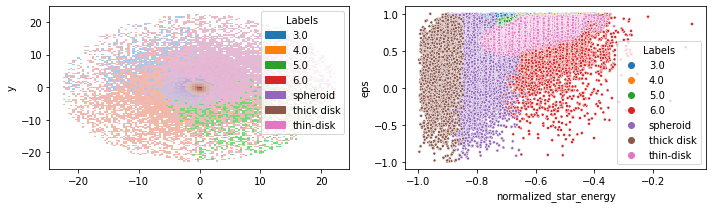

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

gal.plot.hist("x", "y", labels=comp, ax=axs[0])
gal.plot.circ_scatter(
    "normalized_star_energy", "eps", ax=axs[1], labels=comp
)

plt.tight_layout()


## Custom label-maps

As can be seen in the above figures, the color values 
correspond to different components of the galaxy:

- `0` -> spheroid
- `1` -> thin-disk
- `2` -> thick disk

We can provide this information to the `decribe()` and plots methods whit the 
*lmap* (Label-map) parameter, to make more expressive outputs.

In [11]:
lmap = {0: "spheroid", 1: "thin-disk", 2: "thick disk"}

comp.describe(lmap=lmap)

Particles           Deterministic mass            \
                Size  Fraction               Size  Fraction   
spheroid        7223  0.226405       7.158443e+09  0.226200   
thin-disk      13214  0.414193       1.364766e+10  0.431253   
thick disk     11466  0.359402       1.084040e+10  0.342547   

           Probabilistic mass            
                         Size  Fraction  
spheroid         7.574748e+09  0.239355  
thin-disk        1.330450e+10  0.420410  
thick disk       1.076726e+10  0.340235

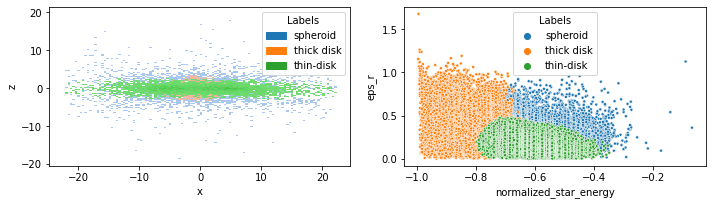

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

gal.plot.hist("x", "z", labels=comp, ax=axs[0], lmap=lmap)
gal.plot.circ_scatter(
    "normalized_star_energy", "eps_r", ax=axs[1], labels=comp, lmap=lmap
)

plt.tight_layout()


## Default label-maps

Some decomposers (such as [JHistogram](../api/models/histogram.rst#galaxychop.models.histogram.JEHistogram)) know in advance which label corresponds 
to which component of the galaxy. For this you can define in the decomposer 
class a `get_lmap()` method that returns the dictionary with the correct lmap.

<div class="alert alert-warning">
**Warning:** This example does not work

This decomposer starts from a random state and there is no a priori way to 
determine which label corresponds to which component.

**This is just a didactic example**.
</div>

So we can extend our decomposer as follows:

In [13]:
import numpy as np


class BGM(DynamicStarsDecomposerMixin, GalaxyDecomposerABC):

    # declare the hyper-parameters
    n_components = hparam(default=3)
    covariance_type = hparam(default="full")
    tol = hparam(default=0.001)
    reg_covar = hparam(default=1e-06)
    max_iter = hparam(default=100)
    n_init = hparam(default=1)
    init_params = hparam(default="kmeans")
    weight_concentration_prior_type = hparam(default="dirichlet_process")
    weight_concentration_prior = hparam(default=None)
    mean_precision_prior = hparam(default=None)
    mean_prior = hparam(default=None)
    degrees_of_freedom_prior = hparam(default=None)
    covariance_prior = hparam(default=None)

    # this convert the random_state to and default_rng object
    random_state = hparam(default=None, converter=np.random.default_rng)

    warm_start = hparam(default=False)
    verbose = hparam(default=0)
    verbose_interval = hparam(default=10)

    def get_attributes(self):
        return ["normalized_star_energy", "eps", "eps_r", "x", "y", "z"]

    def split(self, X, y, attributes):
        # sklearn are not desigined to run with default_rng
        # so here we convert to an old-school np.random.RandomState.
        # Please chek this issue for changes on skleatn behaviour
        # https://github.com/scikit-learn/scikit-learn/issues/16988
        random_state = np.random.RandomState(self.random_state.bit_generator)

        # lets delegate the hyper-parameters to the internal bgm
        bgm = BayesianGaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            tol=self.tol,
            reg_covar=self.reg_covar,
            max_iter=self.max_iter,
            n_init=self.n_init,
            init_params=self.init_params,
            weight_concentration_prior_type=self.weight_concentration_prior_type,
            weight_concentration_prior=self.weight_concentration_prior,
            mean_precision_prior=self.mean_precision_prior,
            mean_prior=self.mean_prior,
            degrees_of_freedom_prior=self.degrees_of_freedom_prior,
            covariance_prior=self.covariance_prior,
            random_state=random_state,
            warm_start=self.warm_start,
            verbose=self.verbose,
            verbose_interval=self.verbose_interval,
        )

        bgm.fit(X)
        labels = bgm.predict(X)

        # calculate the probabilities
        proba = bgm.predict_proba(X)

        # return the labels and the probabilities
        return labels, proba
    
    def get_lmap(self):
        return {0: "spheroid", 1: "thin-disk", 2: "thick disk"}

Let's try how the mass fractions and plots look like now

In [14]:
bgm = BGM()
comp = bgm.decompose(gal)

comp.describe()

Particles           Deterministic mass            \
                Size  Fraction               Size  Fraction   
spheroid        7224  0.226436       7.159108e+09  0.226221   
thin-disk      11466  0.359402       1.084040e+10  0.342547   
thick disk     13213  0.414162       1.364700e+10  0.431232   

           Probabilistic mass            
                         Size  Fraction  
spheroid         7.575063e+09  0.239365  
thin-disk        1.076768e+10  0.340249  
thick disk       1.330377e+10  0.420387

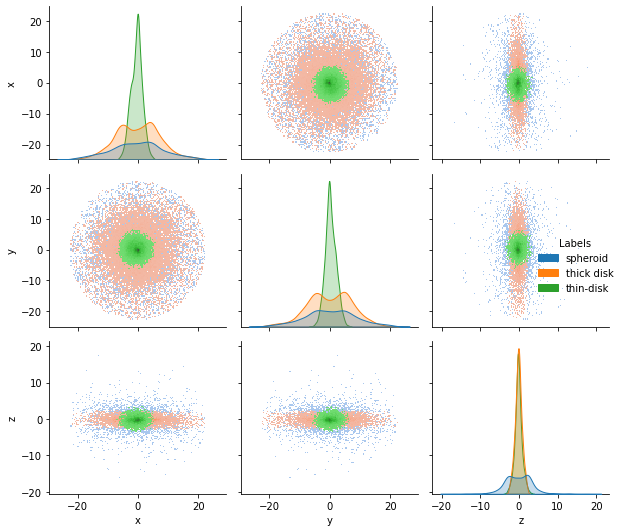

In [15]:
gal.plot(labels=comp)
plt.tight_layout()